In [69]:
# math related packages
import scipy as sc
import qutip as qt
# further packages
from time import time
from random import sample
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics


# ket states
qubit0 = qt.basis(2,0)
qubit1 = qt.basis(2,1)
# density matrices
qubit0mat = qubit0 * qubit0.dag() # it is also possible to use ket2dm(qubit0) 
qubit1mat = qubit1 * qubit1.dag() # it is also possible to use ket2dm(qubit1)



def sigmoid(s,t,u):
    return 1/(1+np.exp(-(s/t)**u))*((np.pi)/2)
def ver_sigmoid(x,y,gamma):
    return x*(-np.log((np.pi/(2*(np.arccos(y**(1/2)))))-1))**(1/gamma)
'''
def sigmoid(x):
    return 1/(1+np.exp(-x))*((np.pi)/2)
def ver_sigmoid(y):
    return -np.log((np.pi/(2*(np.arccos(y**(1/2)))))-1)
'''
def qb_trans(a):# transform normal data to qubit(Bloch sphere representation)
    qubit0 = qt.basis(2,0)
    qubit1 = qt.basis(2,1)
    r=np.cos(a)*qubit0+np.sin(a)*qubit1
    return r

def qb_xtrans(a,b):# transform normal data to qubit(Bloch sphere representation)
    qubit0 = qt.basis(2,0)
    qubit1 = qt.basis(2,1)
    
    r= np.cos(a)*qubit0+np.exp(2*b*1j)*np.sin(a)*qubit1
    return r

def qb_ytrans(a):# transform normal data to qubit(Bloch sphere representation)
    qubit0 = qt.basis(2,0)
    qubit1 = qt.basis(2,1)
    r=np.cos(a)*qubit0+np.sin(a)*qubit1
    return r



def partialTraceKeep(obj, keep): # generalisation of ptrace(), partial trace via "to-keep" list
    # return partial trace:
    res = obj;
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;

def partialTraceRem(obj, rem): # partial trace via "to-remove" list
    # prepare keep list
    rem.sort(reverse=True)
    keep = list(range(len(obj.dims[0])))
    for x in rem:
        keep.pop(x)
    res = obj;
    # return partial trace:
    if len(keep) != len(obj.dims[0]):
        res = obj.ptrace(keep);
    return res;
def swappedOp(obj, i, j):
    if i==j: return obj
    numberOfQubits = len(obj.dims[0])
    permute = list(range(numberOfQubits))
    permute[i], permute[j] = permute[j], permute[i]
    return obj.permute(permute)
def tensoredId(N):
    #Make Identity matrix
    res = qt.qeye(2**N)
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def tensoredQubit0(N):
    #Make Qubit matrix
    res = qt.fock(2**N).proj() #for some reason ran faster than fock_dm(2**N) in tests
    #Make dims list
    dims = [2 for i in range(N)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def unitariesCopy(unitaries): # deep copyof a list of unitaries
    newUnitaries = []
    for layer in unitaries:
        newLayer = []
        for unitary in layer:
            newLayer.append(unitary.copy())
        newUnitaries.append(newLayer)
    return newUnitaries

def randomQubitUnitary(numQubits): # alternatively, use functions rand_unitary and rand_unitary_haar
    dim = 2**numQubits
    #Make unitary matrix
    res = np.random.normal(size=(dim,dim)) + 1j * np.random.normal(size=(dim,dim))
    res = sc.linalg.orth(res)
    res = qt.Qobj(res)
    #Make dims list
    dims = [2 for i in range(numQubits)]
    dims = [dims.copy(), dims.copy()]
    res.dims = dims
    #Return
    return res

def randomQubitState(numQubits): # alternatively, use functions rand_ket and rand_ket_haar
    dim = 2**numQubits
    #Make normalized state
    res = np.random.normal(size=(dim,1)) + 1j * np.random.normal(size=(dim,1))
    res = (1/sc.linalg.norm(res)) * res
    res = qt.Qobj(res)
    #Make dims list
    dims1 = [2 for i in range(numQubits)]
    dims2 = [1 for i in range(numQubits)]
    dims = [dims1, dims2]
    res.dims = dims
    #Return
    return res

def randomTrainingData(unitary, N): # generating training data based on a unitary
    numQubits = len(unitary.dims[0])
    trainingData=[]
    #Create training data pairs
    for i in range(N):
        t = randomQubitState(numQubits)
        ut = unitary*t
        trainingData.append([t,ut])
    #Return
    return trainingData

In [70]:
#def randomNetwork(qnnArch, numTrainingPairs):
def randomNetwork(qnnArch):
    assert qnnArch[0]==qnnArch[-1], "Not a valid QNN-Architecture."
    
    #Create the initial random perceptron unitaries for the network
    networkUnitaries = [[]]
    for l in range(1, len(qnnArch)):
        #print(l)
        numInputQubits = qnnArch[l-1]
        numOutputQubits = qnnArch[l]
        #print(numInputQubits)
        #print(numOutputQubits)
        networkUnitaries.append([])
        for j in range(numOutputQubits):
            unitary = randomQubitUnitary(numInputQubits+1)
            if numOutputQubits-1 != 0: 
                #print(j,"0:",randomQubitUnitary(numInputQubits+1))
                unitary = qt.tensor(randomQubitUnitary(numInputQubits+1), tensoredId(numOutputQubits-1))
                #print(j,"1:",unitary)
                unitary = swappedOp(unitary, numInputQubits, numInputQubits + j)
                #print(j,"2:",unitary)
            networkUnitaries[l].append(unitary)
    #print(networkUnitaries)
    #Return
    #return (qnnArch, networkUnitaries, networkTrainingData, networkUnitary)
    return (qnnArch, networkUnitaries)

In [71]:
def costFunction(trainingData, outputStates):
    costSum = 0
    for i in range(len(trainingData)):
        costSum += trainingData[i][1].dag() * outputStates[i] * trainingData[i][1]
        #print(trainingData[i][1][0])
        #print(trainingData[i][1][0]**2)
        #print(outputStates[i][0,0])
    return costSum.tr()/len(trainingData)
def makeLayerChannel(qnnArch, unitaries, l, inputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]

    #Tensor input state
    state = qt.tensor(inputState, tensoredQubit0(numOutputQubits))

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni

    #Multiply and tensor out input state
    return partialTraceRem(layerUni * state * layerUni.dag(), list(range(numInputQubits)))
def makeAdjointLayerChannel(qnnArch, unitaries, l, outputState):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Prepare needed states
    inputId = tensoredId(numInputQubits)
    state1 = qt.tensor(inputId, tensoredQubit0(numOutputQubits))
    state2 = qt.tensor(inputId, outputState)

    #Calculate layer unitary
    layerUni = unitaries[l][0].copy()
    for i in range(1, numOutputQubits):
        layerUni = unitaries[l][i] * layerUni
    
    #Multiply and tensor out output state
    return partialTraceKeep(state1 * layerUni.dag() * state2 * layerUni, list(range(numInputQubits)) )
def feedforward(qnnArch, unitaries, trainingData):
    storedStates = []
    for x in range(len(trainingData)):
        currentState = trainingData[x][0] * trainingData[x][0].dag()
        layerwiseList = [currentState]
        for l in range(1, len(qnnArch)):
            currentState = makeLayerChannel(qnnArch, unitaries, l, currentState)
            layerwiseList.append(currentState)
        storedStates.append(layerwiseList)
    return storedStates
def makeUpdateMatrix(qnnArch, unitaries, trainingData, storedStates, lda, ep, l, j):
    numInputQubits = qnnArch[l-1]
    
    #Calculate the sum:
    summ = 0
    for x in range(len(trainingData)):
        #Calculate the commutator
        firstPart = updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x)
        secondPart = updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x)
        mat = qt.commutator(firstPart, secondPart)
        
        #Trace out the rest
        keep = list(range(numInputQubits))
        keep.append(numInputQubits + j)
        mat = partialTraceKeep(mat, keep)
        
        #Add to sum
        summ = summ + mat

    #Calculate the update matrix from the sum
    summ = (-ep * (2**numInputQubits)/(lda*len(trainingData))) * summ
    return summ.expm()


def updateMatrixFirstPart(qnnArch, unitaries, storedStates, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Tensor input state
    state = qt.tensor(storedStates[x][l-1], tensoredQubit0(numOutputQubits))
    
    #Calculate needed product unitary
    productUni = unitaries[l][0]
    for i in range(1, j+1):
        productUni = unitaries[l][i] * productUni
    
    #Multiply
    return productUni * state * productUni.dag()


def updateMatrixSecondPart(qnnArch, unitaries, trainingData, l, j, x):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    #Calculate sigma state
    state = trainingData[x][1] * trainingData[x][1].dag()
    for i in range(len(qnnArch)-1,l,-1):
        state = makeAdjointLayerChannel(qnnArch, unitaries, i, state)
    #Tensor sigma state
    state = qt.tensor(tensoredId(numInputQubits), state)
    
    #Calculate needed product unitary
    productUni = tensoredId(numInputQubits + numOutputQubits)
    for i in range(j+1, numOutputQubits):
        productUni = unitaries[l][i] * productUni
        
    #Multiply
    return productUni.dag() * state * productUni


def makeUpdateMatrixTensored(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j):
    numInputQubits = qnnArch[l-1]
    numOutputQubits = qnnArch[l]
    
    res = makeUpdateMatrix(qnnArch, unitaries, lda, ep, trainingData, storedStates, l, j)
    if numOutputQubits-1 != 0:
        res = qt.tensor(res, tensoredId(numOutputQubits-1))
    return swappedOp(res, numInputQubits, numInputQubits + j)
def qnnTraining(qnnArch, initialUnitaries, trainingData, lda, ep, trainingRounds, alert=0):
    
    ### FEEDFORWARD    
    #Feedforward for given unitaries
    s = 0
    currentUnitaries = initialUnitaries
    storedStates = feedforward(qnnArch, currentUnitaries, trainingData)

    #Cost calculation for given unitaries
    outputStates = []
    for k in range(len(storedStates)):
        outputStates.append(storedStates[k][-1])
    plotlist = [[s], [costFunction(trainingData, outputStates)]]
    
    #Optional
    runtime = time()
    
    #Training of the Quantum Neural Network
    for k in range(trainingRounds):
        if alert>0 and k%alert==0: print("In training round "+str(k))
        
        ### UPDATING
        newUnitaries = unitariesCopy(currentUnitaries)
        
        #Loop over layers:
        for l in range(1, len(qnnArch)):
            numInputQubits = qnnArch[l-1]
            numOutputQubits = qnnArch[l]
            
            #Loop over perceptrons
            for j in range(numOutputQubits):
                newUnitaries[l][j] = (makeUpdateMatrixTensored(qnnArch,currentUnitaries,trainingData,storedStates,lda,ep,l,j)* currentUnitaries[l][j])
        
        ### FEEDFORWARD
        
        #Feedforward for given unitaries
        s = s + ep
        currentUnitaries = newUnitaries
        storedStates = feedforward(qnnArch, currentUnitaries, trainingData)
        
        #Cost calculation for given unitaries
        outputStates = []
        for m in range(len(storedStates)):
            outputStates.append(storedStates[m][-1])
            #print(storedStates[m][-1])
        plotlist[0].append(s)
        plotlist[1].append(costFunction(trainingData, outputStates))
        #plotlist[1].append(np.log10(1-costFunction(trainingData, outputStates)))
    
    #Optional
    runtime = time() - runtime
    print("Trained "+str(trainingRounds)+" rounds for a "+str(qnnArch)+" network and "+str(len(trainingData))+" training pairs in "+str(round(runtime, 2))+" seconds")
    print(costFunction(trainingData, outputStates))
    #Return
    return [plotlist, currentUnitaries, outputStates]

In [72]:
x=np.linspace(0,1,501,endpoint=True)
x=x[1:]
print(x)

[0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024
 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046 0.048
 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07  0.072
 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094 0.096
 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118 0.12
 0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142 0.144
 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166 0.168
 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19  0.192
 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214 0.216
 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238 0.24
 0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262 0.264
 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286 0.288
 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304 0.306 0.308 0.31  0.312
 0.314 0.316 0.318 0.32  0.322 0.324 0.326 0.328 0.33

In [73]:
y=np.sin(x)
print(y)

[0.002      0.00399999 0.00599996 0.00799991 0.00999983 0.01199971
 0.01399954 0.01599932 0.01799903 0.01999867 0.02199823 0.0239977
 0.02599707 0.02799634 0.0299955  0.03199454 0.03399345 0.03599222
 0.03799086 0.03998933 0.04198765 0.0439858  0.04598378 0.04798157
 0.04997917 0.05197657 0.05397376 0.05597074 0.05796749 0.05996401
 0.06196029 0.06395632 0.06595209 0.06794761 0.06994285 0.07193781
 0.07393248 0.07592686 0.07792093 0.07991469 0.08190814 0.08390125
 0.08589403 0.08788647 0.08987855 0.09187027 0.09386163 0.09585261
 0.09784321 0.09983342 0.10182322 0.10381262 0.10580161 0.10779017
 0.1097783  0.11176599 0.11375324 0.11574003 0.11772635 0.11971221
 0.12169758 0.12368247 0.12566687 0.12765076 0.12963414 0.13161701
 0.13359934 0.13558114 0.1375624  0.13954311 0.14152327 0.14350285
 0.14548186 0.14746029 0.14943813 0.15141537 0.15339201 0.15536803
 0.15734343 0.15931821 0.16129234 0.16326583 0.16523867 0.16721084
 0.16918235 0.17115318 0.17312332 0.17509278 0.17706153 0.17902

In [74]:
x=x*((np.pi)/2)
y=y*((np.pi)/2)

In [75]:
x_train,x_test,y_train,y_test = train_test_split(x, y,test_size=0.2,random_state=1)


In [76]:
trainingData=[]
for i in range(len(x_train)):

    u=qb_trans(x_train[i])

    ut=qb_trans(y_train[i])

    trainingData.append([u,ut])
    

In training round 0
In training round 10
In training round 20
In training round 30
In training round 40
In training round 50
In training round 60
In training round 70
In training round 80
In training round 90
In training round 100
In training round 110
In training round 120
In training round 130
In training round 140
In training round 150
In training round 160
In training round 170
In training round 180
In training round 190
Trained 200 rounds for a [1, 2, 1] network and 400 training pairs in 918.77 seconds
0.9925174435107366


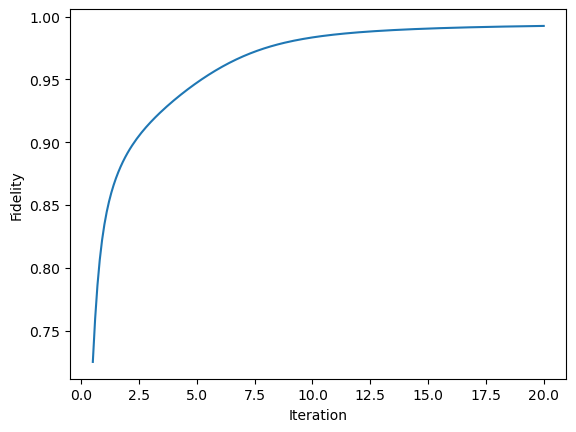

In [77]:
network121 = randomNetwork([1,2,1])
trained121_result=qnnTraining(network121[0], network121[1], trainingData, 1, 0.1, 200,10)
plotlist121 = trained121_result[0]

for i in range(len(plotlist121[1])):
    if plotlist121[1][i] >= 0.9999:
        print("Exceeds cost of 0.9999 at training step "+str(i))
        break

plt.plot(plotlist121[0][5:], plotlist121[1][5:])
plt.xlabel("Iteration")
plt.ylabel("Fidelity")
plt.show()



In [79]:
train_out=trained121_result[2]
train_out_y_list=[]
for i in range(len(y_train)):
    
    train_out_y=train_out[i][0,0]

    train_out_y_list.append(float(train_out_y))

y_train=np.cos(y_train)**2

train_MSE=metrics.mean_squared_error(y_train,train_out_y_list)
train_RMSE=train_MSE**(1/2)

train_MAE=metrics.mean_absolute_error(y_train,train_out_y_list)
train_MAPE=metrics.mean_absolute_percentage_error(y_train,train_out_y_list)
train_R2=metrics.r2_score(y_train, train_out_y_list)
print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)


train_MSE: 0.00034787125834389595
train_RMSE: 0.018651307148398365
train_MAE: 0.015634166453020414
train_MAPE: 0.03560873909757634
train_R2: 0.9966151732063419


C:\Users\73\AppData\Local\Temp\ipykernel_18592\616158082.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  train_out_y_list.append(float(train_out_y))


In [80]:
#################test####################
testData=[]
for i in range(len(x_test)):
    u=qb_trans(x_test[i])
    #print(u)
    testData.append([u])
    
#y_test=(np.cos(sigmoid(y_test)))**2

learnedUnitaries = trained121_result[1]

storedStates = feedforward([1,2,1], learnedUnitaries, testData)
outputStates = []
for k in range(len(storedStates)):
    t_qstate=storedStates[k][-1]

    t_out=t_qstate[0,0]

    outputStates.append(float(t_out))

    
y_test=np.cos(y_test)**2

test_MSE=metrics.mean_squared_error(y_test,outputStates)
test_RMSE=test_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(y_test,outputStates)
test_MAPE=metrics.mean_absolute_percentage_error(y_test,outputStates)
test_R2=metrics.r2_score(y_test, outputStates)


print("test_MSE:",test_MSE)
print("test_RMSE:",test_RMSE)
print("test_MAE:",test_MAE)
print("test_MAPE:",test_MAPE)
print("test_R2:",test_R2)


test_MSE: 0.00032425519056258423
test_RMSE: 0.01800708723149261
test_MAE: 0.015278262668304508
test_MAPE: 0.03764026876983628
test_R2: 0.9966969023926295


C:\Users\73\AppData\Local\Temp\ipykernel_18592\2816640269.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  outputStates.append(float(t_out))
